Scope acquisition
=================

In this tutorial we will demonstrate the sequencer based scope acquisition procedure allowing you to inspect and process the raw input
of the Pulsar QRM. We will also have a look at how to average multiple scope acquisitions in hardware (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#acquisitions)). We will show this by using a Pulsar QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the Pulsar QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import pprint
import os
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from pulsar_qrm.pulsar_qrm import pulsar_qrm

#Connect to the Pulsar QRM at default IP address.
pulsar = pulsar_qrm("qrm", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_status())

Status:
{'status': 'OKAY', 'flags': []}


Generate waveforms
-----------------

Next, we need to create the waveforms for the sequence.

In [2]:
#Waveform parameters
waveform_length = 120 #nanoseconds
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": [], "index": 0},
                "sine":     {"data": [], "index": 1}
            }

#Create gaussian waveform
if "gaussian" in waveforms:
    waveforms["gaussian"]["data"] = scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length)

#Create sine waveform
if "sine" in waveforms:
    waveforms["sine"]["data"] = [math.sin((2*math.pi/waveform_length)*i) for i in range(0, waveform_length)]

Let's plot the waveforms to see what we have created.

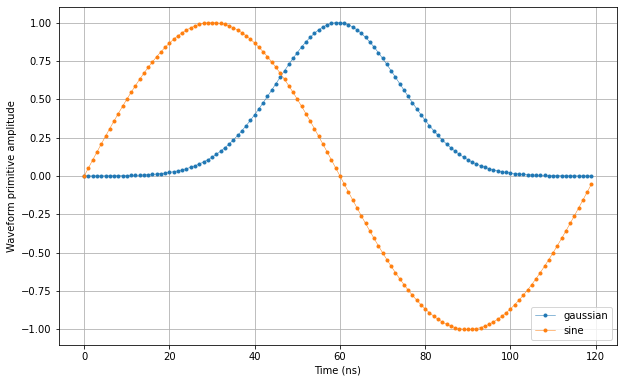

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()

matplotlib.pyplot.draw()
matplotlib.pyplot.show()   # add this at EOF to prevent execution stall

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 5 acquisition specifications that
each create a single bin. However, we will not be using the bins in this turorial.

In [4]:
#Acquisitions
acquisitions = {"single":       {"num_bins": 1,
                                 "index": 0},
                "multiple_0":   {"num_bins": 1,
                                 "index": 1},
                "multiple_1":   {"num_bins": 1,
                                 "index": 2},
                "multiple_2":   {"num_bins": 1,
                                 "index": 3},
                "avg":          {"num_bins": 1,
                                 "index": 4}}

Create Q1ASM program
--------------------

Now that we have the waveforms and acquisitions specification for the sequence, we need a simple Q1ASM program that sequences and acquires the waveforms.

In [5]:
#Sequence program.
seq_prog = """
play    0,1,4     #Play waveforms and wait 4ns.
acquire 0,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
stop              #Stop.
"""

Upload sequence
---------------

Now that we have the waveform and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [6]:
#Reformat waveforms to lists if necessary.
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [7]:
#Upload waveforms and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers to trigger the acquisition with the `acquire` instruction.

In [8]:
#Configure the sequencer to trigger the scope acquisition.
pulsar.scope_acq_sequencer_select(0)
pulsar.scope_acq_trigger_mode_path0("sequencer")
pulsar.scope_acq_trigger_mode_path1("sequencer")

#Map sequencer to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        pulsar.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar.sequencer0_channel_map_path0_out0_en(True)
pulsar.sequencer0_channel_map_path1_out1_en(True)

Now let's start the sequence.

In [9]:
#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs. Lets make sure that the sequencer has finished it's acquisition and then retrieve the
resulting data. The acquisition data is stored in a temporary memory in the instrument's FPGA. We need to first move the data from this memory into the into the
instrument's acquisition list. From there we can retrieve it from the instrument.

In [10]:
#Wait for the sequencer to stop with a timeout period of one minute.
pulsar.get_sequencer_state(0, 1)

#Wait for the acquisition to finish with a timeout period of one minute.
pulsar.get_acquisition_state(0, 1)

#Move acquisition data from temporary memory to acquisition list.
pulsar.store_scope_acquisition(0, "single")
    
#Get acquisition list from instrument.
single_acq = pulsar.get_acquisitions(0)

Let's plot the result.

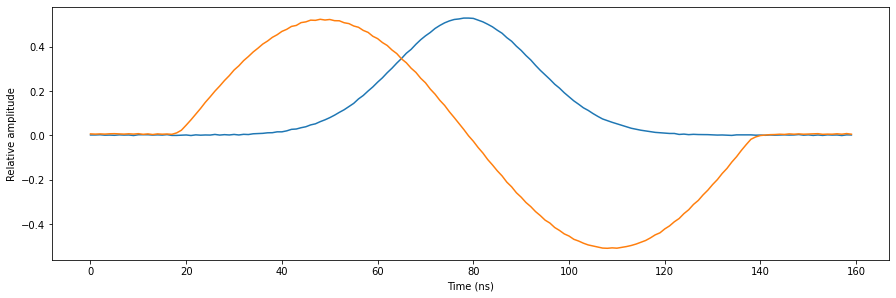

In [11]:
#Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(single_acq["single"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Retrieve multiple acquisitions
------------------------------

We can also run the sequence multiple times consecutively and store the acquisition data in the instrument's acquisition list before retrieving them all in
one go. To demonstrate this we will run the same sequence three times and vary the output gain for each run to create a clear distinction between the acquisitions.

In [12]:
#First run
pulsar.sequencer0_gain_awg_path0(0.33)
pulsar.sequencer0_gain_awg_path1(0.33)

pulsar.arm_sequencer(0)
pulsar.start_sequencer()

pulsar.get_sequencer_state(0, 1)
pulsar.get_acquisition_state(0, 1)

pulsar.store_scope_acquisition(0, "multiple_0")

#Second run
pulsar.sequencer0_gain_awg_path0(0.66)
pulsar.sequencer0_gain_awg_path1(0.66)

pulsar.arm_sequencer(0)
pulsar.start_sequencer()

pulsar.get_sequencer_state(0, 1)
pulsar.get_acquisition_state(0, 1)

pulsar.store_scope_acquisition(0, "multiple_1")

#Second run
pulsar.sequencer0_gain_awg_path0(1)
pulsar.sequencer0_gain_awg_path1(1)

pulsar.arm_sequencer(0)
pulsar.start_sequencer()

pulsar.get_sequencer_state(0, 1)
pulsar.get_acquisition_state(0, 1)

pulsar.store_scope_acquisition(0, "multiple_2")

#Get acquisition list from instrument.
multiple_acq = pulsar.get_acquisitions(0)

Let's plot the result again.

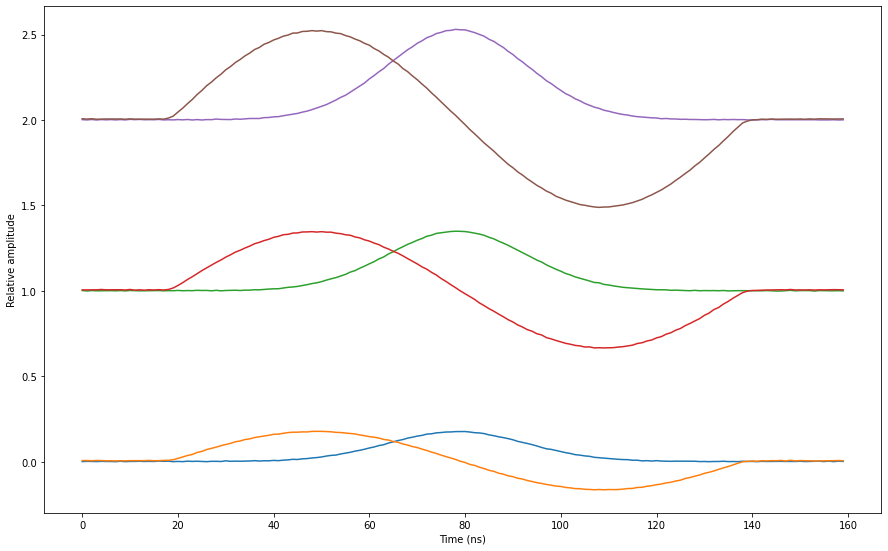

In [13]:
#Plot acquired signals (add acquisition index to separate acquisitions in plot).
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 1.61))
for acq_idx in range(0, 3):
    ax.plot(numpy.array(multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"]["path0"]["data"][130:290]) + acq_idx)
    ax.plot(numpy.array(multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"]["path1"]["data"][130:290]) + acq_idx)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Hardware-based averaging
------------------------

We can also use hardware in the instrument itself to automatically accumulate acquisition data on-the-fly. This can be used to do averaging, by dividing the final
accumulated result by the number of accumulations. To use this feature, we first need to modify the Q1ASM to run the sequence multiple consecutive times.

In [14]:
#Sequence program.
seq_prog = """
      move    1000,R0   #Loop iterator.

loop: play    0,1,4     #Play waveforms and wait 4ns.
      acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
      loop    R0,@loop  #Run until number of iterations is done.

      stop              #Stop.
"""

Next, we need to program, configure and start the sequencer. This time we will also configure the sequencer to run in averaging mode.

In [15]:
#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence_avg.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

#Upload waveforms and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence_avg.json"))

#Enable hardware averaging
pulsar.scope_acq_avg_mode_en_path0(True)
pulsar.scope_acq_avg_mode_en_path1(True)

#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Wait for sequence and acquisitions to finish.
pulsar.get_sequencer_state(0, 1)
pulsar.get_acquisition_state(0, 1)

#Move accumulated result from temporary memory to the instrument's acquisition list.
pulsar.store_scope_acquisition(0, "avg")

#Get acquisition list from instrument.
avg_acq = pulsar.get_acquisitions(0)

The sequence has now run and accumulated a 1000 times. Time to finish the averaging process and print the result.

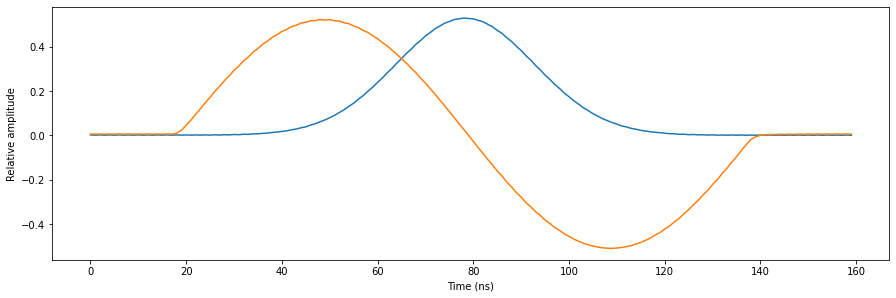

In [16]:
#Plot results.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][130:290]))
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path1"]["data"][130:290]))
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Note that the accumulated acquisitions have already been averaged when the data is returned. The instrument keeps track of the number of accumulations and divides the result upon returning the data. The number of accumulations is also available for review.

In [17]:
#Print number of averages
print(avg_acq["avg"]["acquisition"]["scope"]["path0"]["avg_cnt"])
print(avg_acq["avg"]["acquisition"]["scope"]["path1"]["avg_cnt"])

1000
1000


To show that the hardware averaging worked, let's compare and zoom in on the data from the very first acquisition in this tutorial and the very last.

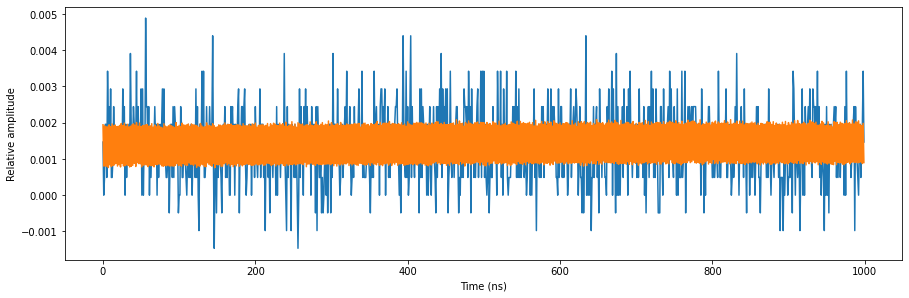

In [18]:
#Plot results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(numpy.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [19]:
#Stop sequencer.
pulsar.stop_sequencer()
    
#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE OVERWRITTEN PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ SCOPE OVERWRITTEN PATH 1', 'ACQ BINNING DONE']}

Snapshot:
qrm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
in0_gain                                    :	-6 (dB)
in1_gain                                    :	-6 (dB)
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
reference_source                            :	internal 
scope_acq_avg_mode_en_path0                 :	True 
scope_acq_avg_mode_en_path1                 :	True 
scope_acq_sequencer_select                  :	0 
scope_acq_trigger_level_path0               :	0 
scope_acq_trigger_level_path1               :	0 
scope_acq_trigger_mode_path0                :	sequencer 
scope_